In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model, preprocessing, svm
from sklearn.preprocessing import StandardScaler, Normalizer
import math
import matplotlib
import seaborn as sns

# read data from csv file
original = pd.read_csv('autos.csv', sep=',', header=0, encoding='cp1252')
print(original.head(5))
original = original.head(10000)
# Check data statistics
original.describe()

           dateCrawled                            name  seller offerType  \
0  2016-03-24 11:52:17                      Golf_3_1.6  privat   Angebot   
1  2016-03-24 10:58:45            A5_Sportback_2.7_Tdi  privat   Angebot   
2  2016-03-14 12:52:21  Jeep_Grand_Cherokee_"Overland"  privat   Angebot   
3  2016-03-17 16:54:04              GOLF_4_1_4__3TÜRER  privat   Angebot   
4  2016-03-31 17:25:20  Skoda_Fabia_1.4_TDI_PD_Classic  privat   Angebot   

   price abtest vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480   test         NaN                1993    manuell        0   golf   
1  18300   test       coupe                2011    manuell      190    NaN   
2   9800   test         suv                2004  automatik      163  grand   
3   1500   test  kleinwagen                2001    manuell       75   golf   
4   3600   test  kleinwagen                2008    manuell       69  fabia   

   kilometer  monthOfRegistration fuelType       brand notRepairedDamage  

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000
mean,5817.501800,2003.503400,113.597700,125434.000000,5.732800,0.0,50688.451600
std,10035.521164,11.699413,106.623799,40231.436724,3.717901,0.0,25852.917457
min,0.000000,1111.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1150.000000,1999.000000,69.000000,100000.000000,3.000000,0.0,30419.000000
50%,2990.000000,2003.500000,106.500000,150000.000000,6.000000,0.0,49477.000000
75%,7299.000000,2008.000000,150.000000,150000.000000,9.000000,0.0,71229.000000
max,579000.000000,2018.000000,7515.000000,150000.000000,12.000000,0.0,99986.000000


In [33]:
# Restructuring -> Vertical Decomposition
# drop low impact data on price

# seller, offerType, abtest -> has one or two data.
# nrOfPictures -> has only 0.
# dataCrawled, lastSeen, dataCreated -> information about data crawling
# postalCode -> postal information
original.drop(['seller', 'offerType', 'abtest', 'dateCrawled', 'nrOfPictures', 'lastSeen', 'postalCode', 'dateCreated'],
              axis='columns', inplace=True)

In [34]:
# Cleaning dirty data



# Remove unusable data(redundant data)
data = original.drop_duplicates(['name','price','vehicleType','yearOfRegistration'
                         ,'gearbox','powerPS','model','kilometer','monthOfRegistration','fuelType'
                         ,'notRepairedDamage'])

# Remove the outliers and wrong data
# if price < 100 -> wrong data
# if price > 150000 -> the outliers
data = data[
        (data.yearOfRegistration <= 2016) 
      & (data.yearOfRegistration >= 1950) 
      & (data.price >= 100)
      & (data.price <= 150000) 
      & (data.powerPS >= 10) 
      & (data.powerPS <= 500)]


In [35]:
# Check null data
data.isnull().sum()

name                      0
price                     0
vehicleType             309
yearOfRegistration        0
gearbox                 144
powerPS                   0
model                   286
kilometer                 0
monthOfRegistration       0
fuelType                415
brand                     0
notRepairedDamage      1091
dtype: int64

In [36]:
# Missing Data

# 'model' ->  very high impact data on price -> essential for price prediction
# --> need to drop null data in 'model' column
data = data[data.model.notnull()]



# Replace null with others
# Replace with the most value according to model type.
for i in range(len(data.model.unique())) : 
    data["vehicleType"].fillna(data.vehicleType[data["model"]==data.model.unique()[i]].value_counts().head(1).index[0], inplace=True)
    data["fuelType"].fillna(data.fuelType[data["model"]==data.model.unique()[i]].value_counts().head(1).index[0], inplace=True)
    data["gearbox"].fillna(data.gearbox[data["model"]==data.model.unique()[i]].value_counts().head(1).index[0], inplace=True)

# null in 'notRepairedDamage' is one of the deciding factors for price prediction.
# -> replace null with 'not-declared'
data["notRepairedDamage"].fillna(value='not-declared', inplace=True)

# Check whether the misting data is processed well.
print("\n\n** After **")
print(data.isnull().sum())

print("\n\n** Size **")
print(len(data))



** After **
name                   0
price                  0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dtype: int64


** Size **
7964


In [37]:
# 스트링 콜럼만 뽑아냄
labels = ['gearbox', 'notRepairedDamage', 'model', 'brand', 'fuelType', 'vehicleType']
les = {}

# name 추출

# 스트링인 콜럼을 encoder해서 다시 기존의 데이터에 추가
# label encoder
for l in labels:
    les[l] = preprocessing.LabelEncoder()
    les[l].fit(data[l].astype(str))
    tr = les[l].transform(data[l].astype(str)) 
    data.loc[:, l + '_encode'] = pd.Series(tr, index=data.index)

# 필요한 정보만 다시 뽑아냄 --> 새로운 데이터
labeled = data[ ['price'
                        ,'yearOfRegistration'
                        ,'powerPS'
                        ,'kilometer'
                        ,'monthOfRegistration'] 
                    + [x+"_encode" for x in labels]]

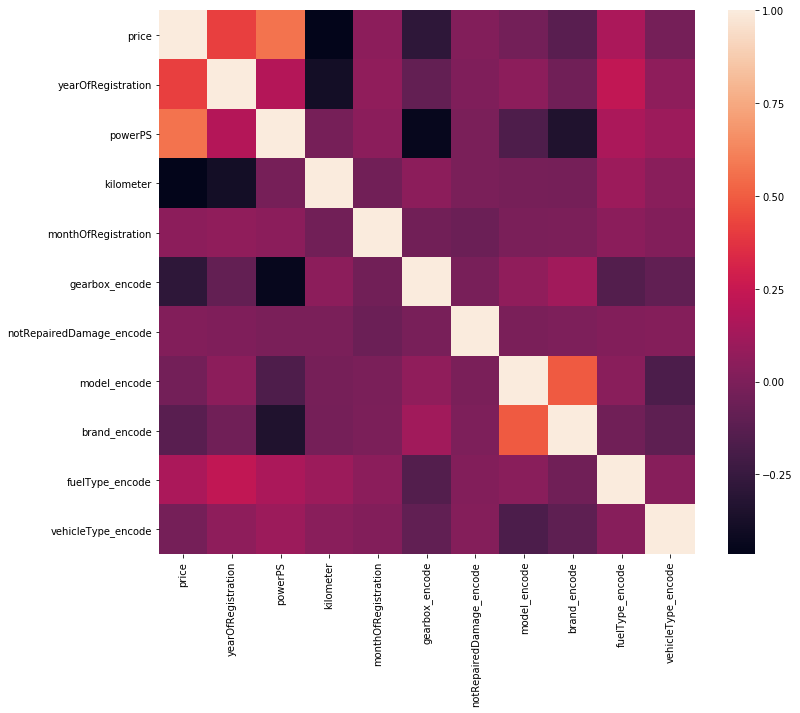

In [38]:

# calculate the correlation matrix
corr = labeled.corr()
# size 조정
plt.subplots( figsize =( 12 , 10 ) )
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [39]:

# Split X and Y
Y = labeled['price']
X = labeled.drop(['price'], axis='columns', inplace=False)

# standardization 수행
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scale = scaler.fit_transform(X)
X_scale = pd.DataFrame(X_scale, columns = X.columns)
print(X_scale)
print(Y)


      yearOfRegistration   powerPS  kilometer  monthOfRegistration  \
0               0.090639  0.587245   -0.00159             0.543056   
1              -0.373375 -0.879270    0.63156            -0.021331   
2               0.709325 -0.979260   -0.88800             0.260863   
3              -1.301403 -0.429317    0.63156             1.107443   
4               0.090639 -0.312662    0.63156             0.543056   
5               1.637353 -0.046023   -2.40756             0.543056   
6              -0.837389 -0.445982    0.63156            -1.714493   
7               0.090639 -0.379322    0.63156             1.671831   
8               0.245311  0.203951    0.63156             1.671831   
9              -1.301403 -0.212673    0.63156             1.389637   
10              0.090639  0.053966    0.63156            -1.150106   
11              1.173339  1.037198   -1.39452            -0.867912   
12              1.946696 -1.129244    0.63156            -1.714493   
13              0.09

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123456)



In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor()

param_grid = { "criterion" : ["mse"]
              , "min_samples_leaf" : [3]
              , "min_samples_split" : [3]
              , "max_depth": [10]
              , "n_estimators": [500]}

gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=-1, verbose=1)
gs = gs.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   17.5s finished


In [46]:
bp = gs.best_params_
randomForest = RandomForestRegressor(criterion=bp['criterion'],
                              min_samples_leaf=bp['min_samples_leaf'],
                              min_samples_split=bp['min_samples_split'],
                              max_depth=bp['max_depth'],
                              n_estimators=bp['n_estimators'],
                              oob_score=True)
randomForest.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [47]:
predicted = randomForest.predict(X_test)
y_predict = pd.Series(predicted)

print("TEST")
print(y_test)
print("PREDICT")
print(y_predict)
print("ACCURACY")
# print(type(y_test))
# print(y_test.iloc[0])
y_test = y_test.reset_index(drop=True)
y_predict = y_predict.reset_index(drop=True)
temp = (y_test - y_predict).abs().sort_values().index
#print(temp)

print("***",len(temp))
for i in temp:
    print("Original: ", y_test.iloc[i])
    print("Predicted: ", y_predict.iloc[i])
    print()



TEST
0        4990
1         400
2        1450
3         599
4        7150
5         650
6        3799
7        2000
8        3750
9        1100
10      12950
11       1000
12      25900
13       6999
14      16000
15       2800
16       2600
17       2550
18        899
19        200
20       2000
21       2250
22      10986
23       4800
24       3999
25        300
26       1400
27       1050
28      15490
29       3600
        ...  
2360     1650
2361     6000
2362     1350
2363     3300
2364    15700
2365     1350
2366    13350
2367     1000
2368     2900
2369      500
2370     5900
2371     2600
2372      150
2373      250
2374     1049
2375     3399
2376    14950
2377     1850
2378     7999
2379     3500
2380     1300
2381      650
2382      780
2383    11550
2384     1599
2385     6500
2386      390
2387    10000
2388     2699
2389     3000
Name: price, Length: 2390, dtype: int64
PREDICT
0        5105.666695
1        2041.265797
2        3408.649542
3         866.256603
4        

Original:  4650
Predicted:  4424.965853499753

Original:  1600
Predicted:  1826.9164867316697

Original:  1500
Predicted:  1727.2528150600372

Original:  2500
Predicted:  2272.6987089678933

Original:  2700
Predicted:  2472.3734249345075

Original:  1490
Predicted:  1718.1354794942845

Original:  1950
Predicted:  2178.7463474672595

Original:  2150
Predicted:  1921.2363888095142

Original:  1400
Predicted:  1171.1040006019107

Original:  1100
Predicted:  870.3665913245794

Original:  1000
Predicted:  1229.6756290557557

Original:  1650
Predicted:  1879.764665308797

Original:  2200
Predicted:  1969.856588729747

Original:  3800
Predicted:  4030.516699721877

Original:  1150
Predicted:  919.3760545119128

Original:  850
Predicted:  1080.8462921529997

Original:  1699
Predicted:  1467.6694701435113

Original:  4500
Predicted:  4268.058550802415

Original:  2990
Predicted:  3223.3540880693013

Original:  1199
Predicted:  1432.536280040104

Original:  899
Predicted:  664.8504800810605

Ori

Original:  2900
Predicted:  2535.2427959752576

Original:  4700
Predicted:  4333.991681498905

Original:  1300
Predicted:  932.1749974603307

Original:  690
Predicted:  1058.3103614131205

Original:  2500
Predicted:  2131.4769135755305

Original:  699
Predicted:  1068.072925756252

Original:  2500
Predicted:  2870.455058006452

Original:  3300
Predicted:  2928.6308574532422

Original:  1400
Predicted:  1028.6044925908013

Original:  2800
Predicted:  3171.404502030522

Original:  700
Predicted:  1072.4673851231885

Original:  1000
Predicted:  1373.0739448790066

Original:  12950
Predicted:  12576.652636008468

Original:  750
Predicted:  1123.3805951909935

Original:  7300
Predicted:  7673.518948650482

Original:  800
Predicted:  1175.8455458228545

Original:  500
Predicted:  876.3111234841892

Original:  7500
Predicted:  7123.610196666315

Original:  2800
Predicted:  2423.4642495479166

Original:  1400
Predicted:  1777.2556439825469

Original:  500
Predicted:  877.6827415834498

Origina

Predicted:  1108.8094611551635

Original:  10333
Predicted:  9772.360906679642

Original:  1500
Predicted:  939.1216184931927

Original:  150
Predicted:  711.5925791089394

Original:  2999
Predicted:  2436.4693189370028

Original:  1350
Predicted:  785.9385269478507

Original:  800
Predicted:  1364.9571736892099

Original:  5990
Predicted:  5422.5447824103185

Original:  2999
Predicted:  2431.010703801635

Original:  1250
Predicted:  1818.8070096641004

Original:  499
Predicted:  1068.072925756252

Original:  3200
Predicted:  3769.4759195342517

Original:  5500
Predicted:  4930.0571366091535

Original:  2000
Predicted:  2570.0116230903686

Original:  3200
Predicted:  3770.3728640606614

Original:  5200
Predicted:  4629.1109404262215

Original:  1400
Predicted:  1970.9527513795463

Original:  750
Predicted:  1321.6956606954973

Original:  500
Predicted:  1072.2001588378416

Original:  17950
Predicted:  17377.66384869498

Original:  590
Predicted:  1165.3773231527343

Original:  1100
Pre

Predicted:  1408.8087273409687

Original:  3450
Predicted:  2640.706499919687

Original:  3000
Predicted:  2189.712545295225

Original:  5599
Predicted:  4788.671679592461

Original:  6880
Predicted:  6067.535178287798

Original:  3500
Predicted:  2687.2008624467494

Original:  500
Predicted:  1316.665532738399

Original:  4000
Predicted:  3182.6056450116844

Original:  400
Predicted:  1218.9859488714822

Original:  1000
Predicted:  1820.0182335884047

Original:  2500
Predicted:  3320.6040163969724

Original:  400
Predicted:  1222.8995901092076

Original:  10450
Predicted:  11273.31555801849

Original:  17499
Predicted:  16675.394852701025

Original:  1699
Predicted:  2522.881604919408

Original:  1500
Predicted:  2324.840699644453

Original:  29900
Predicted:  30725.00538369688

Original:  5850
Predicted:  6675.572926054054

Original:  6500
Predicted:  7326.469438677444

Original:  6600
Predicted:  5773.469860316799

Original:  300
Predicted:  1127.5508637114128

Original:  1700
Predi

Predicted:  7933.4845920789885

Original:  1999
Predicted:  3233.6887511163322

Original:  1000
Predicted:  2238.115617676871

Original:  800
Predicted:  2038.2199656396203

Original:  2800
Predicted:  4039.1849796215756

Original:  8850
Predicted:  10089.81694757195

Original:  14399
Predicted:  15640.233411774696

Original:  2850
Predicted:  1608.4152169047952

Original:  13299
Predicted:  14541.602466054406

Original:  400
Predicted:  1643.903658275874

Original:  2399
Predicted:  1152.5505678615334

Original:  9800
Predicted:  8551.915174275446

Original:  950
Predicted:  2198.4263918536626

Original:  12900
Predicted:  11650.933508605174

Original:  10500
Predicted:  11752.27279140927

Original:  850
Predicted:  2104.8836935715417

Original:  1000
Predicted:  2254.998300789661

Original:  9500
Predicted:  8237.638331028958

Original:  6650
Predicted:  7913.196037609132

Original:  8750
Predicted:  7486.511132731814

Original:  699
Predicted:  1963.6318402208908

Original:  4600
Pr

Predicted:  8629.048721546918

Original:  11500
Predicted:  13130.374682123153

Original:  2999
Predicted:  1367.5917210671175

Original:  3800
Predicted:  5435.643480818641

Original:  6800
Predicted:  5162.215600639776

Original:  8499
Predicted:  10139.147284300474

Original:  7850
Predicted:  6209.253872742481

Original:  400
Predicted:  2041.265796811236

Original:  1860
Predicted:  3505.3601553634703

Original:  5650
Predicted:  4003.487250553402

Original:  9850
Predicted:  8200.563466360187

Original:  8000
Predicted:  6347.126412048985

Original:  5699
Predicted:  7351.903881612728

Original:  22989
Predicted:  21335.366254811754

Original:  1400
Predicted:  3054.633672552177

Original:  3400
Predicted:  1744.6668918605328

Original:  2100
Predicted:  3755.6996701285007

Original:  7900
Predicted:  9556.464294029669

Original:  9499
Predicted:  11162.399633159572

Original:  24199
Predicted:  25863.933596565148

Original:  14900
Predicted:  16564.96204118603

Original:  5200
P


Original:  16200
Predicted:  18440.175691484154

Original:  7999
Predicted:  10240.26546403556

Original:  6500
Predicted:  8747.353852385255

Original:  11650
Predicted:  9400.286968472432

Original:  4999
Predicted:  7250.5262162051795

Original:  14200
Predicted:  11945.75782449041

Original:  12900
Predicted:  10644.032458757238

Original:  14990
Predicted:  12732.561303119352

Original:  13999
Predicted:  11741.333339406778

Original:  4500
Predicted:  2236.941525364819

Original:  44000
Predicted:  46273.310655655456

Original:  17900
Predicted:  20177.474308943016

Original:  7950
Predicted:  10229.49940015386

Original:  6500
Predicted:  4218.13539499137

Original:  12599
Predicted:  10316.278326715821

Original:  2399
Predicted:  4682.567553466877

Original:  6500
Predicted:  8795.901480304794

Original:  5800
Predicted:  3494.4328539297835

Original:  7650
Predicted:  9959.133748728858

Original:  4900
Predicted:  2584.2728195703985

Original:  5950
Predicted:  3620.89767639

Original:  9500
Predicted:  4916.381689624487

Original:  7000
Predicted:  2398.503119510081

Original:  2900
Predicted:  7504.490056562751

Original:  20399
Predicted:  15772.470701250784

Original:  13499
Predicted:  18160.5822782305

Original:  35500
Predicted:  30819.495255418566

Original:  23500
Predicted:  18803.0302442724

Original:  1550
Predicted:  6250.04525010019

Original:  9900
Predicted:  14602.794430976204

Original:  24300
Predicted:  19594.77906396302

Original:  11999
Predicted:  16704.233301004486

Original:  20900
Predicted:  25605.849469638193

Original:  9500
Predicted:  14252.489438478708

Original:  5000
Predicted:  9898.502590116155

Original:  24500
Predicted:  29435.289839288194

Original:  13999
Predicted:  18966.14975688501

Original:  8300
Predicted:  13323.245829881116

Original:  3399
Predicted:  8435.679572563533

Original:  26999
Predicted:  21954.77666840537

Original:  8900
Predicted:  13958.49838130566

Original:  8500
Predicted:  3437.075910110559

In [48]:
print('Score: %.2f' % randomForest.score(X_test, y_test))

# from sklearn.metrics import accuracy_score

# predicted = forest.predict(X_test)
# accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {forest.oob_score_:.3}')
# print(f'Mean accuracy score: {accuracy:.3}')

Score: 0.83
Out-of-bag score estimate: 0.776


In [14]:
def MAPE(actual, predict):

    sum_actuals = sum_errors = 0

    for actual_val, predict_val in zip(actual, predict):
        abs_error = actual_val - predict_val
        if abs_error < 0:
            abs_error = abs_error * -1

        sum_errors = sum_errors + abs_error
        sum_actuals = sum_actuals + actual_val

    mean_abs_percent_error = sum_errors / sum_actuals
    print("MAPE: ")
    print(mean_abs_percent_error)
    print("Accuracy using MAPE: ")
    print(1-mean_abs_percent_error)

In [15]:
MAPE(y_test, y_predict)

MAPE: 
0.2688997727004285
Accuracy using MAPE: 
0.7311002272995715
